# Image Classification using CNN by mohammad mahdi khaki

connect to google drive
and copy files:
dataset , test dataset , model (if exist)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/MyDataset" "/content/"

In [3]:
!cp -r "/content/drive/MyDrive/MyTestDataset" "/content/"


In [26]:
!cp -r "/content/drive/MyDrive/MyModel" "/content/"


Library Import

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from tensorflow import keras

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib

import matplotlib.pyplot as plt


Load and preprocess dataset

In [5]:
data_dir = pathlib.Path("/content/MyDataset")

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


128


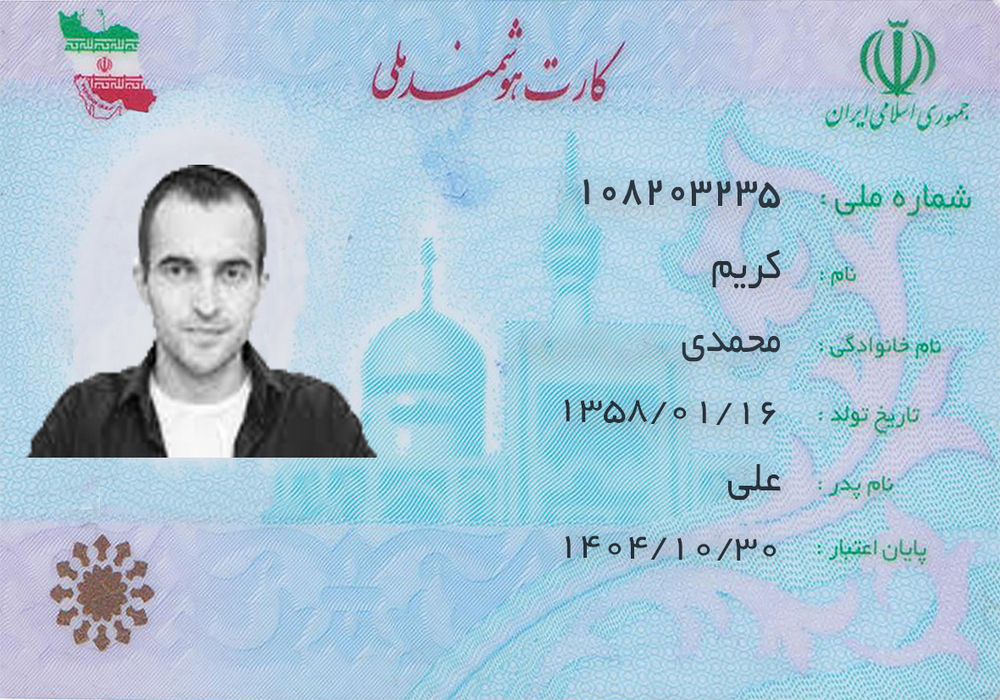

In [7]:
kartmelli = list(data_dir.glob('kartmelli/*'))
PIL.Image.open(str(kartmelli[0]))


In [8]:
batch_size = 32
img_height = 180
img_width = 180


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 128 files belonging to 4 classes.
Using 103 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 128 files belonging to 4 classes.
Using 25 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)


['govahinameh', 'kartmashin', 'kartmelli', 'shenasnameh']


Visualize the data

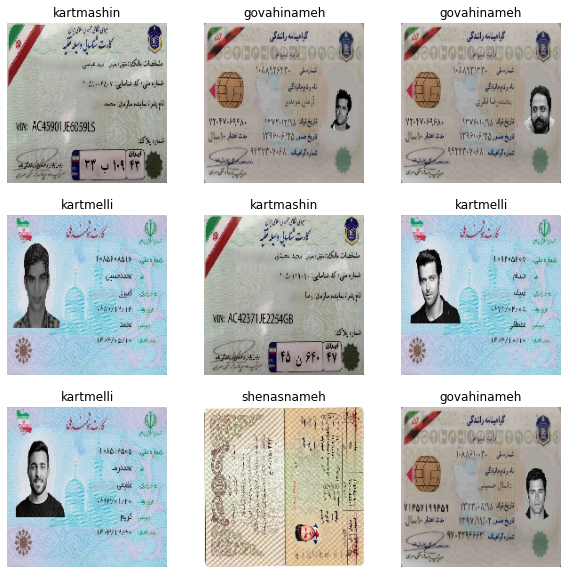

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1]

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9960066


Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [20]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 107584)            0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10, )

Epoch 1/10
4/4 [==============================] - 10s 243ms/step - loss: 747.9509 - accuracy: 0.2039 - val_loss: 228.5107 - val_accuracy: 0.2800
Epoch 2/10
4/4 [==============================] - 0s 31ms/step - loss: 150.1331 - accuracy: 0.1359 - val_loss: 17.5850 - val_accuracy: 0.2800
Epoch 3/10
4/4 [==============================] - 0s 31ms/step - loss: 13.7664 - accuracy: 0.4369 - val_loss: 0.7967 - val_accuracy: 0.6800
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 0.8629 - accuracy: 0.7573 - val_loss: 0.1484 - val_accuracy: 0.9600
Epoch 5/10
4/4 [==============================] - 0s 31ms/step - loss: 0.1079 - accuracy: 0.9320 - val_loss: 4.5232 - val_accuracy: 0.5200
Epoch 6/10
4/4 [==============================] - 0s 31ms/step - loss: 0.6498 - accuracy: 0.9223 - val_loss: 1.4976 - val_accuracy: 0.8400
Epoch 7/10
4/4 [==============================] - 0s 31ms/step - loss: 0.1608 - accuracy: 0.9806 - val_loss: 0.8489 - val_accuracy: 0.6400
Epoch 8/10
4/4 [=

### Evaluate the model

1/1 - 0s - loss: 7.1526e-08 - accuracy: 1.0000 - 15ms/epoch - 15ms/step


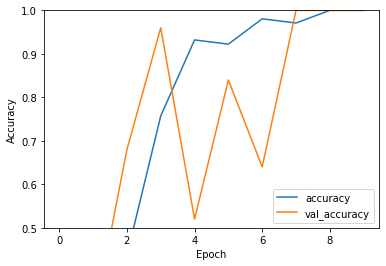

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

In [24]:
print(test_acc)

1.0


save model

In [30]:
model.save('/content/MyModel/model.h5')

load model

In [31]:
new_model = tf.keras.models.load_model('/content/MyModel/model.h5')

In [32]:
loss, acc = new_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


1/1 - 0s - loss: 7.1526e-08 - accuracy: 1.0000 - 142ms/epoch - 142ms/step
Restored model, accuracy: 100.00%


predict class

In [45]:
#testdata_url = "https://siteurl.org/example_images/testdata.jpg"
#testdata_path = tf.keras.utils.get_file('testdata', origin=testdata_url)

testdata_path = "/content/MyTestDataset/3.jpg"

img = tf.keras.utils.load_img(
    testdata_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 15ms/step
This image most likely belongs to kartmelli with a 100.00 percent confidence.


This simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code!